# MLB Standings

In [1]:
import libs.brscraper as brscraper
import pandas as pd
import numpy as np
%matplotlib inline
scraper = brscraper.BRScraper()
import libs.chart_format as chart_format
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_teams = pd.read_csv('inputs\mlb_teams.csv')

In [3]:
df_teams.head()

,team,league,division,r,g,b
0,ari,nl,west,167,25,48
1,atl,nl,east,19,39,79
2,bal,al,east,223,70,1
3,bos,al,east,189,48,57
4,chc,nl,central,14,51,134


In [4]:
def calculate_records(year):

    df_standings = pd.DataFrame()
    
    for team in df_teams.team:
    
        url =  "teams/%s/%s-schedule-scores.shtml#team_schedule::none" % (team.upper(), str(year))
        #print team, url
        data = scraper.parse_tables(url)

        df = pd.DataFrame(data['team_schedule'])
        df = df[['Tm', 'W-L']]
        df_record = pd.DataFrame(df['W-L'].str.split('-').tolist(), columns = ['W','L'])
        df = df_record.join(df['Tm'])

        df['W'] = pd.to_numeric(df['W'])
        df['L'] = pd.to_numeric(df['L'])

        df['over_500'] = df.W - df.L
        df = df[df.index < 162]

        # When teams have nothing left to play for in the regular season (i.e. Cubs 2016), they won't 
        # always make up rainouts. Baseball reference adds in playoff games at the end of each team's 
        # schedule, which makes games over .500 plummet. We'll remove these and the front fill games
        # over .500 later
        df['diff'] = df['W'].diff()
        df = df[(df['diff'] >= -1) | (df.index == df.index.min())]
        df = df[['Tm', 'over_500']]

        srs = pd.Series(df.over_500, name=team)
        
        df_standings = pd.concat((df_standings, srs), axis=1)
        
    df_standings = df_standings.fillna(method='ffill')

    df_standings.index += 1
    
    return df_standings

In [5]:
def divison_standings(year, league, division):

    df_div = df[df_teams['team'][(df_teams.league == league) & (df_teams.division == division)]]
    colors = np.array(df_teams[['r','g','b']][(df_teams.league == league) & (df_teams.division ==division)])
    
    reload(chart_format)
    
    fig = chart_format.format_line_chart(df_div, colors=colors, title='%s %s %s standings' % (str(year), league, division) )
    
    return fig
    

In [6]:
df = calculate_records(2016)

In [7]:
df = pd.read_csv('outputs/2016.csv')
df_teams = pd.read_csv('inputs\mlb_teams.csv')

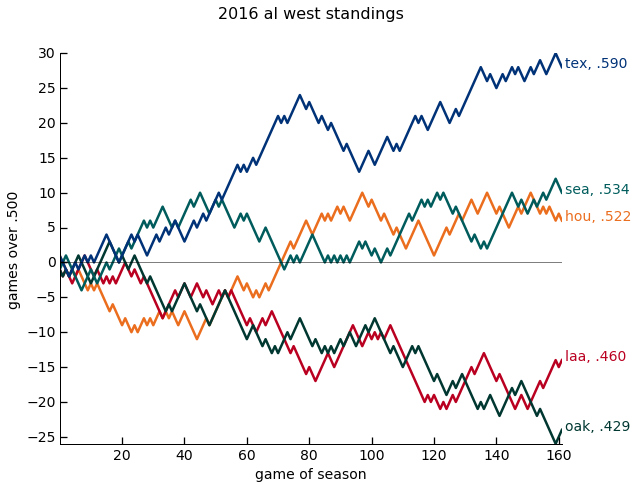

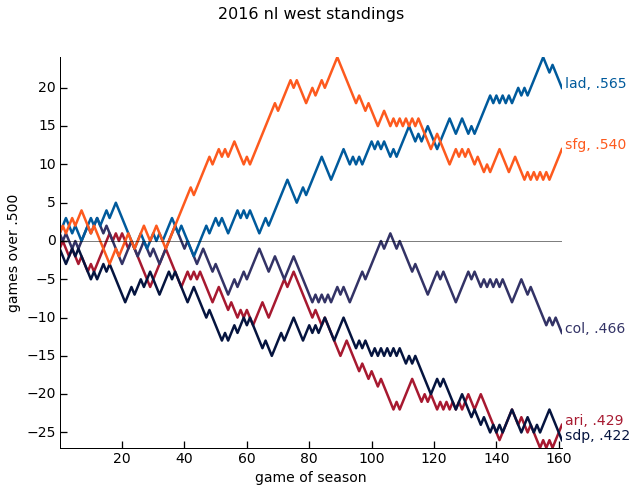

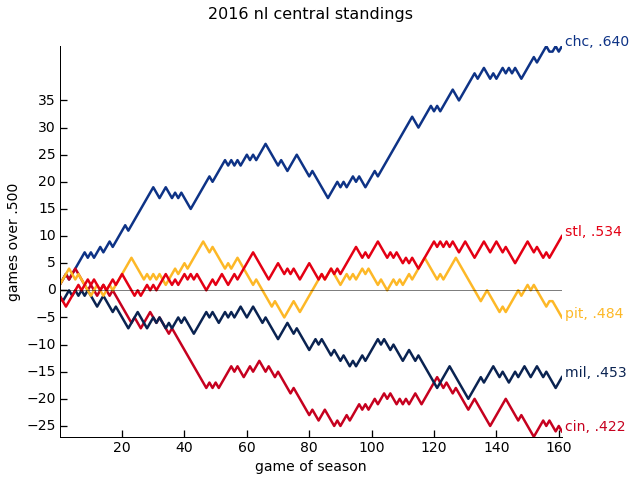

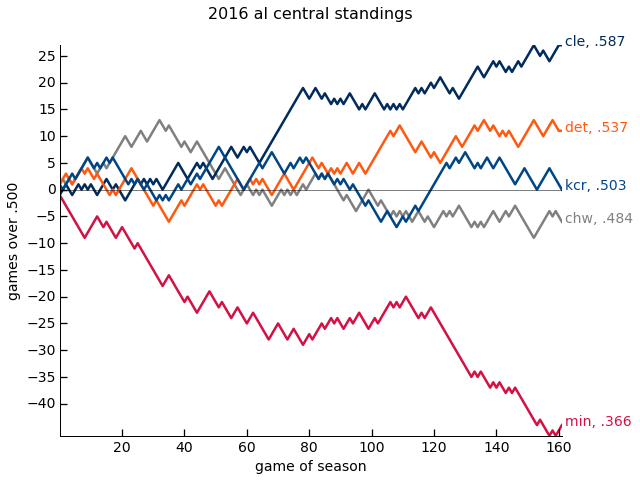

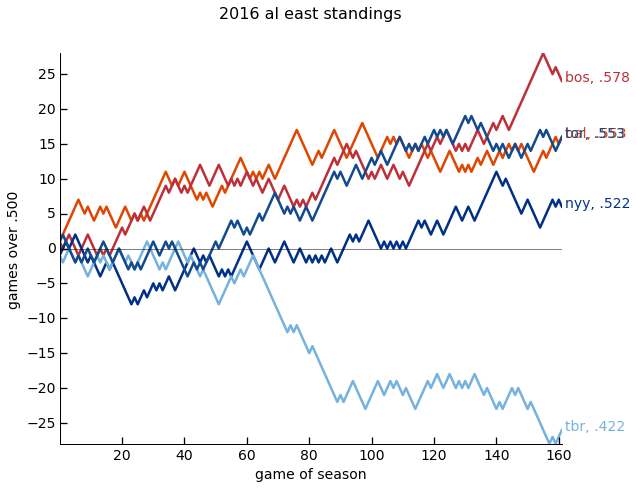

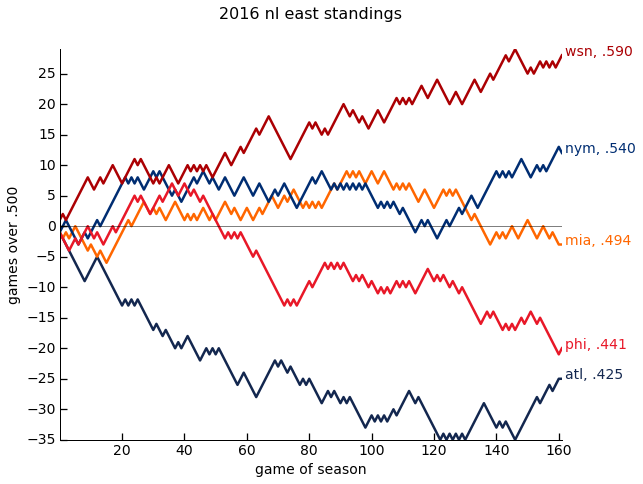

In [8]:
al_west = divison_standings(year='2016', league='al', division='west')
nl_west = divison_standings(year='2016', league='nl', division='west')
nl_central = divison_standings(year='2016', league='nl', division='central')
al_central = divison_standings(year='2016', league='al', division='central')
al_east = divison_standings(year='2016', league='al', division='east')
nl_east = divison_standings(year='2016', league='nl', division='east')

In [9]:
nl_central.savefig(r'images\2016\nl_central_2016.png', bbox_inches='tight')
al_central.savefig(r'images\2016\al_central_2016.png', bbox_inches='tight')
nl_east.savefig(r'images\2016\nl_east_2016.png', bbox_inches='tight')
al_east.savefig(r'images\2016\al_east_2016.png', bbox_inches='tight')
nl_west.savefig(r'images\2016\nl_west_2016.png', bbox_inches='tight')
al_west.savefig(r'images\2016\al_west_2016.png', bbox_inches='tight')
df.to_csv('outputs/2016.csv')